In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats


import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ipywidgets as widgets
from ipywidgets import interact

%matplotlib inline

## Data processing

In [2]:
Country_in_Interest = ['Canada', 'France', 'Germany', 'United Kingdom', 'United States', 'Italy', 'India']

In [3]:
apple_data_raw = pd.read_csv('./data/applemobilitytrends-2021-05-07.csv')
traffic_data = apple_data_raw[apple_data_raw['geo_type']=='country/region']
traffic_data = traffic_data.drop(columns=['geo_type','alternative_name','sub-region','country'])
traffic_data = traffic_data.groupby('region').mean()
traffic_data = traffic_data.reset_index().melt('region')
traffic_data.columns=['Country','Date','Traffic']
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'])
traffic_data = traffic_data[traffic_data['Country'].isin(Country_in_Interest)]
traffic_data = traffic_data[~traffic_data['Date'].isin(['2020-05-11','2020-05-12'])]

C:\Users\mkof6\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
who_data_raw = pd.read_csv('./data/WHO-COVID-19-global-data.csv')
who_data = who_data_raw.drop(columns=['Country_code','WHO_region','Cumulative_cases','New_deaths','Cumulative_deaths'])
who_data.columns = ['Date', 'Country', "Cases"]
who_data['Date']=pd.to_datetime(who_data['Date'])
Country_dic = {'The United Kingdom':'United Kingdom', 'United States of America':'United States'}
who_data['Country'] = who_data['Country'].replace(Country_dic)
who_data = who_data[who_data['Country'].isin(Country_in_Interest)]

In [5]:
finaldf = pd.merge(traffic_data,who_data, on=['Country','Date'], how='inner')

In [6]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3353 entries, 0 to 3352
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Country  3353 non-null   object        
 1   Date     3353 non-null   datetime64[ns]
 2   Traffic  3346 non-null   float64       
 3   Cases    3353 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 131.0+ KB


In [7]:
finaldf.head()

,Country,Date,Traffic,Cases
0,Canada,2020-01-13,100.0,0
1,France,2020-01-13,100.0,0
2,Germany,2020-01-13,100.0,0
3,India,2020-01-13,100.0,0
4,Italy,2020-01-13,100.0,0


In [8]:
def add_rolling_avg(df, periods=7):
    unique_countries = df['Country'].unique()
    for i in range(len(unique_countries)):
        df_ = df[df['Country'] == unique_countries[i]].copy()
        df_['traffic_roll_avg'] = df_['Traffic'].rolling(periods).mean()
        df_['cases_roll_avg'] = df_['Cases'].rolling(periods).mean()
        if i == 0:
            output = df_
        else:
            output = pd.concat([output, df_])
    return output.reset_index().drop(columns = ['index'])

In [9]:
finaldf = add_rolling_avg(finaldf)

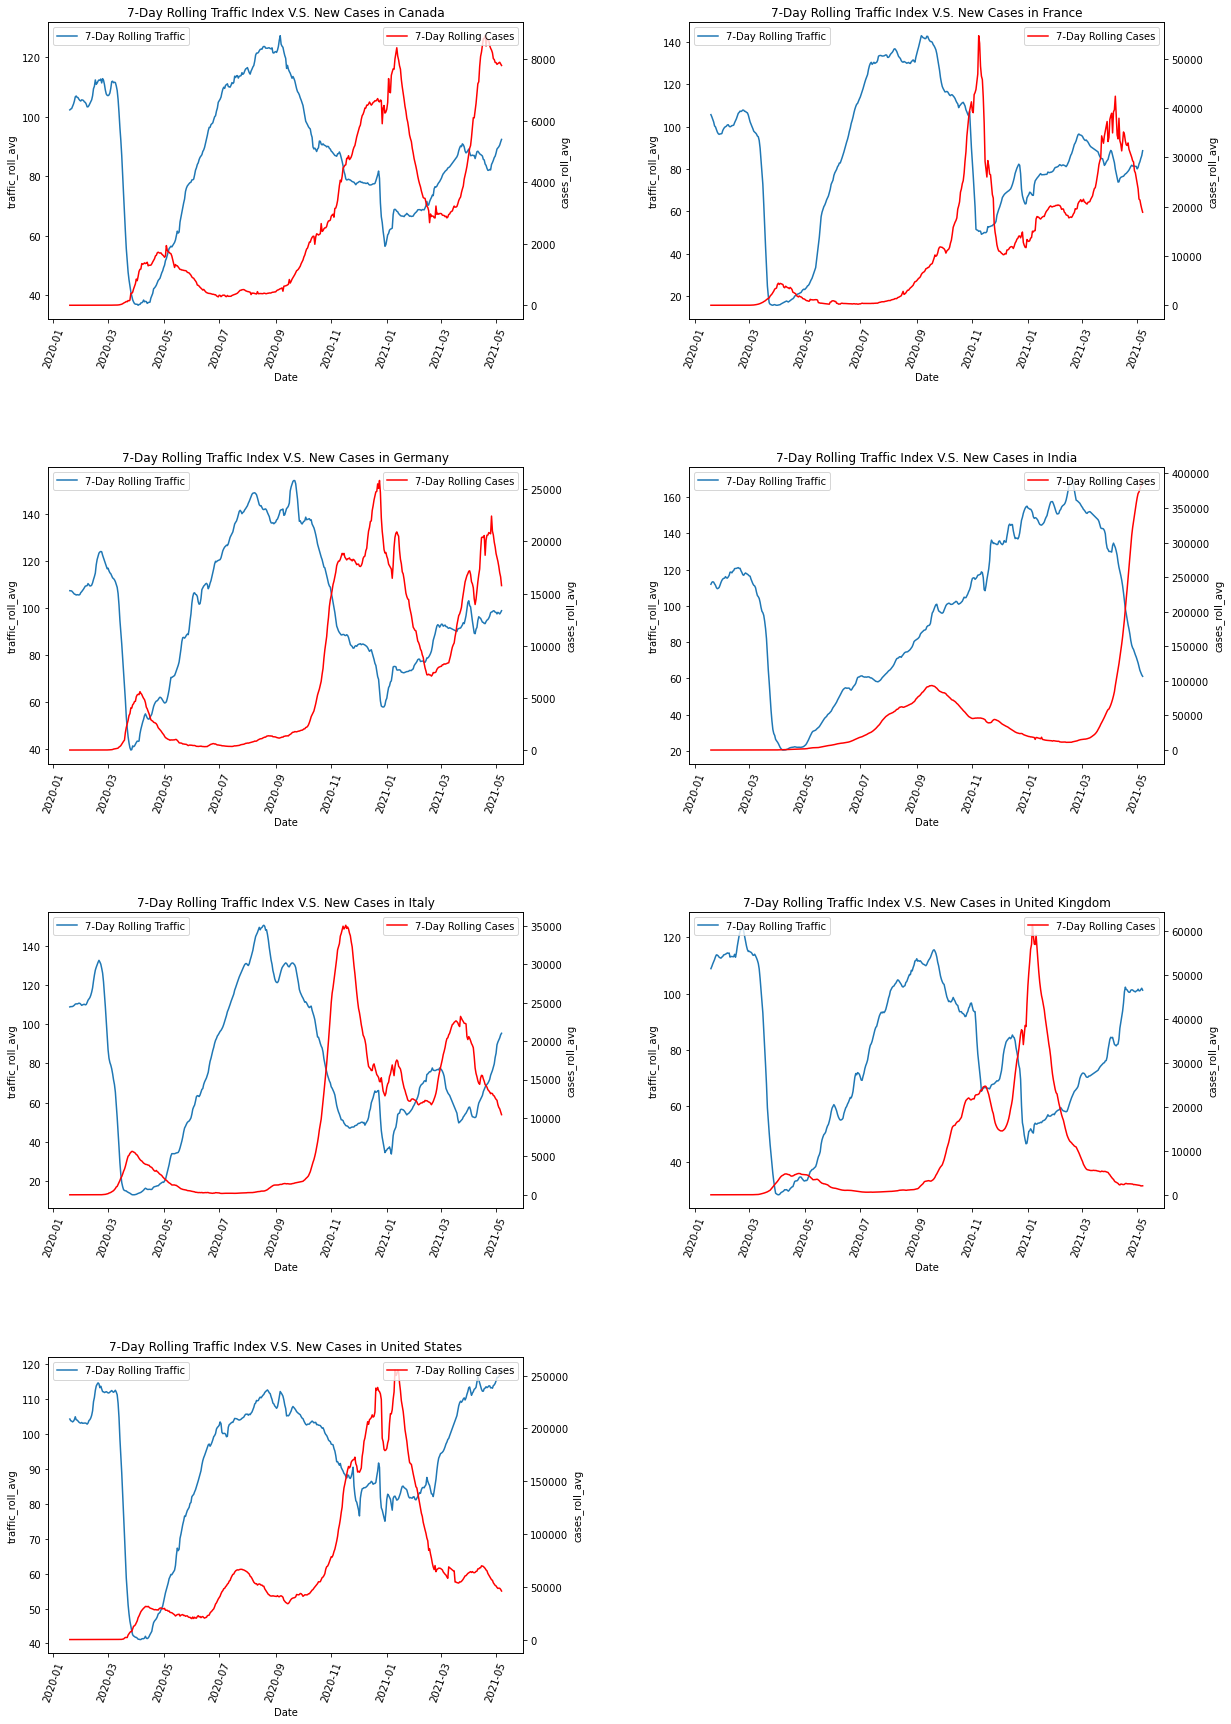

In [10]:
# Now, since we've got 7 countries in the list, let's plot our data into a 4x2
i=1
for country in finaldf['Country'].unique():
    df = finaldf[finaldf['Country']==country].copy()
    fig = plt.gcf()
    fig.set_size_inches(20, 30)
    ax = fig.add_subplot(4, 2, i)

    sns.lineplot(x=df['Date'],y=df['traffic_roll_avg'], ax=ax, label='7-Day Rolling Traffic', legend=False)
    ax2 = ax.twinx()
    sns.lineplot(x=df['Date'],y=df['cases_roll_avg'], ax=ax2, color='red', label = '7-Day Rolling Cases', legend=False)
    
    ax.set_title('7-Day Rolling Traffic Index V.S. New Cases in {}'.format(country))
    plt.gcf().subplots_adjust(hspace=0.5, wspace=0.35)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
    ax.legend(loc='upper left')
    ax2.legend(loc = 'upper right')
    i+=1

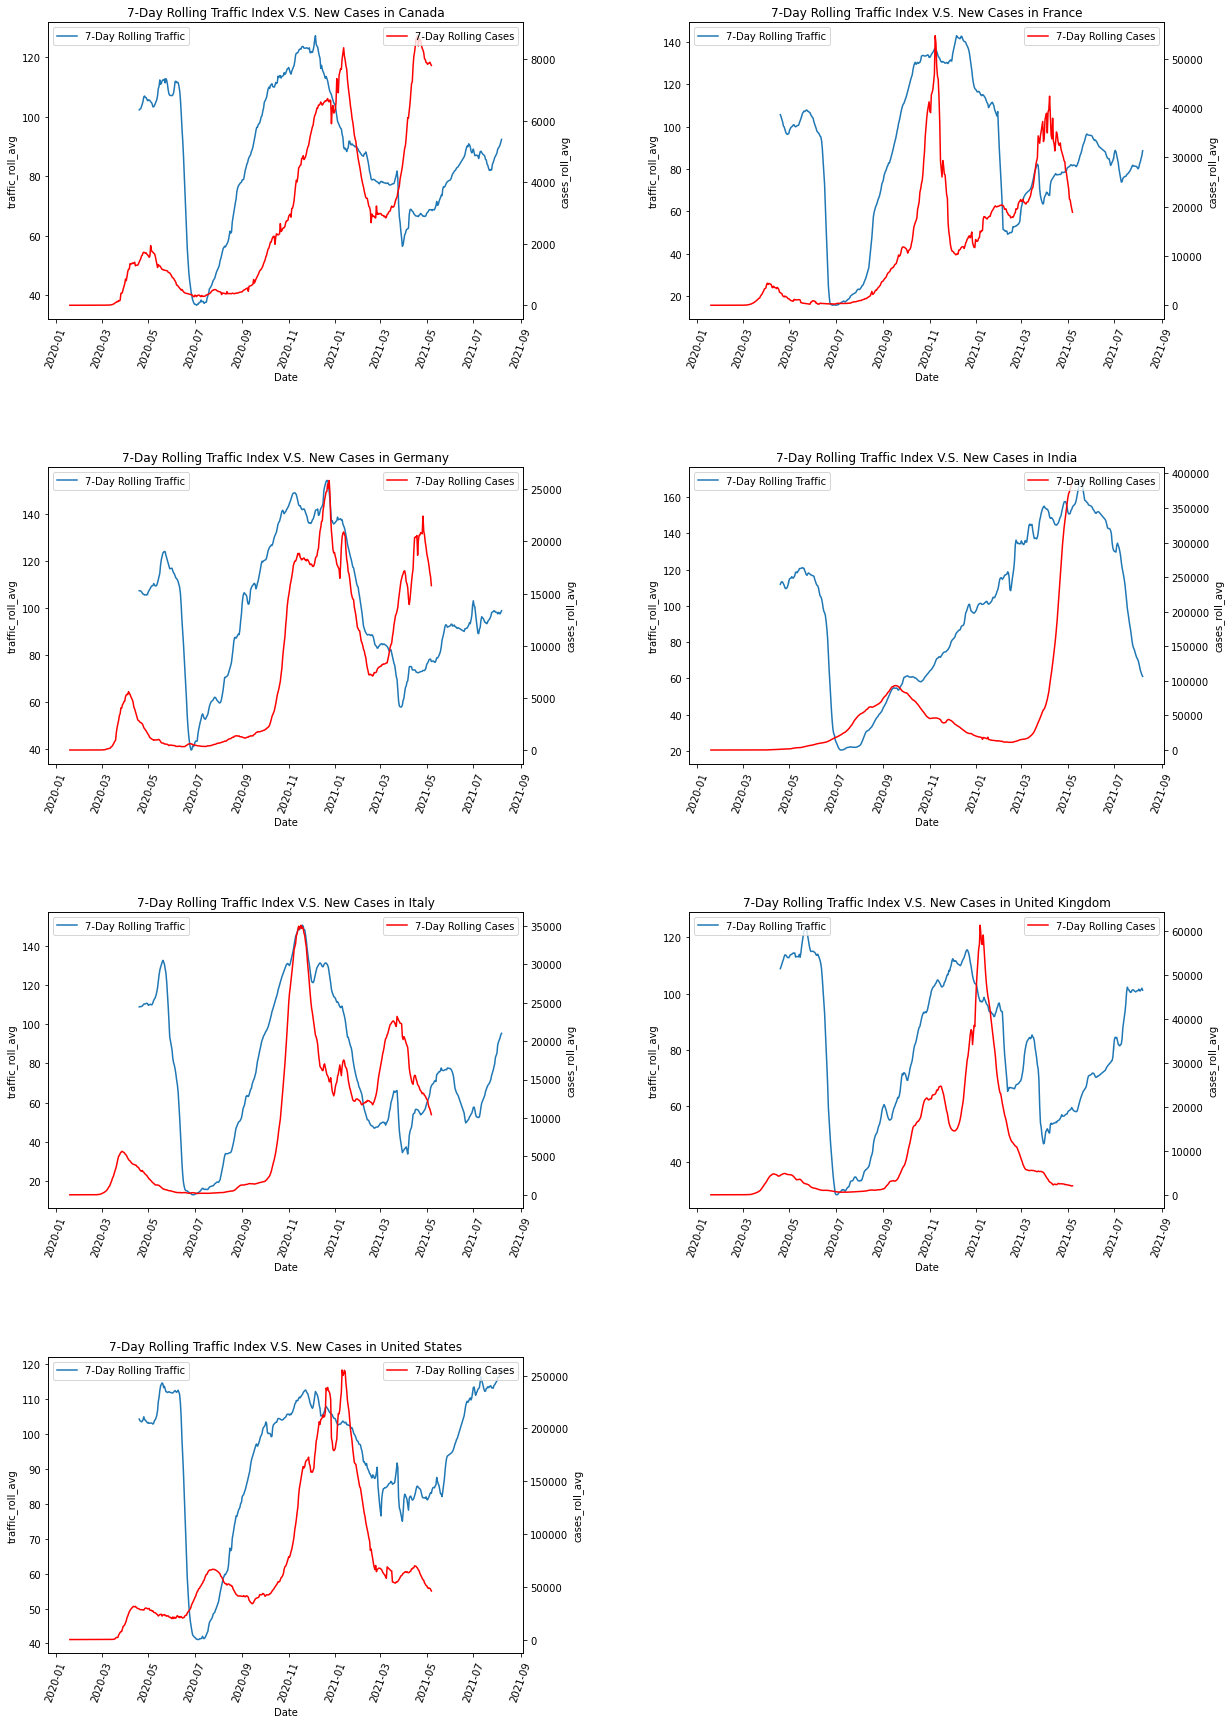

In [11]:
# I've always have the assumed that more traffic will lead to more new cases of Covid-19, 
# as it means that people are not 'staying at home being isolated', it leads to more opportunities for the virus to spread.
# With that, I would expect new cases to rise following the rise of the traffic
# From the charts above, it seems that the new cases seems to rise abouth 3 months after the rising of the traffic
# Let's add a 3 month to our traffic data and see if that is the case

plus_month_period=3
i=1
for country in finaldf['Country'].unique():
    df = finaldf[finaldf['Country']==country].copy()
    fig = plt.gcf()
    fig.set_size_inches(20, 30)
    ax = fig.add_subplot(4, 2, i)
    i+=1
    sns.lineplot(x=df['Date']+pd.DateOffset(months=plus_month_period),y=df['traffic_roll_avg'], ax=ax, label='7-Day Rolling Traffic', legend=False)
    ax2 = ax.twinx()
    sns.lineplot(x=df['Date'],y=df['cases_roll_avg'], ax=ax2, color='red', label = '7-Day Rolling Cases', legend=False)
    
    ax.set_title('7-Day Rolling Traffic Index V.S. New Cases in {}'.format(country))
    plt.gcf().subplots_adjust(hspace=0.5, wspace=0.35)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
    ax.legend(loc='upper left')
    ax2.legend(loc = 'upper right')

In [25]:
# To allow further fine tuning of the date offset,
# we can use days as the unit and utilize the interact slider in ipywidgets

import ipywidgets as widgets
from ipywidgets import interact, Layout

@interact(plus_day_period = widgets.IntSlider(
    value = 100,
    min=-180,
    max=180,
    step=1,
    description='Days to Offset:',
    style = {'description_width': 'initial'},
    disabled=False,
    continuous_updaet=False,
    orientation = 'horizontal',
    readout=True,
    readout_format = 'd',
    layout=Layout(width='50%', height='80px')
)
)

def plotting(plus_day_period):
    i=1
    for country in finaldf['Country'].unique():
        df = finaldf[finaldf['Country']==country].copy()
        fig = plt.gcf()
        fig.set_size_inches(15, 23)
        ax = fig.add_subplot(4, 2, i)
        i+=1
        sns.lineplot(x=df['Date']+pd.DateOffset(days=plus_day_period),y=df['traffic_roll_avg'], ax=ax, label='7-Day Rolling Traffic', legend=False)
        ax2 = ax.twinx()
        sns.lineplot(x=df['Date'],y=df['cases_roll_avg'], ax=ax2, color='red', label = '7-Day Rolling Cases', legend=False)

        ax.set_title('7-Day Rolling Traffic Index V.S. New Cases in {}'.format(country))
        plt.gcf().subplots_adjust(hspace=0.5, wspace=0.35)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
        ax.legend(loc='upper left')
        ax2.legend(loc = 'upper right')

interactive(children=(IntSlider(value=100, description='Days to Offset:', layout=Layout(height='80px', width='…

In [13]:
df_USA = finaldf[finaldf['Country'] == 'United States'].reset_index().drop(columns=['index']).copy()

In [14]:
df_USA.head()

,Country,Date,Traffic,Cases,traffic_roll_avg,cases_roll_avg
0,United States,2020-01-13,100.000000,0,NaN,NaN
1,United States,2020-01-14,100.110000,0,NaN,NaN
2,United States,2020-01-15,101.966667,0,NaN,NaN
3,United States,2020-01-16,102.706667,0,NaN,NaN
4,United States,2020-01-17,118.300000,0,NaN,NaN


In [15]:
def plot_Traffic_VS_Cases(df, days2shift = 90, country = 'United States', show_original_traffic = False):
    
    input_df = df[df['Country'] == country].reset_index().drop(columns=['index']).copy()
    
    input_df['Traffic_rolling_shifted'] = input_df['traffic_roll_avg'].shift(periods = days2shift, fill_value = 0)

    plot_shift = max(days2shift, 180)

    df_plot = input_df[plot_shift:]

    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    ax = fig.add_subplot()
    if show_original_traffic:
        sns.lineplot(x=df_plot['Date'],y=df_plot['traffic_roll_avg'], ax=ax, label='7-Day Rolling Traffic', legend=False)
    sns.lineplot(x=df_plot['Date'],y=df_plot['Traffic_rolling_shifted'], ax=ax, label='7-Day Rolling Traffic_Shifted', legend=False)
    ax2 = ax.twinx()
    sns.lineplot(x=df_plot['Date'],y=df_plot['cases_roll_avg'], ax=ax2, color='red', label = '7-Day Rolling New Cases', legend=False)

    ax.set_title(f'Traffic Index V.S. New Cases in {country}')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
    ax.legend(loc='upper left')
    ax2.legend(loc = 'upper right')


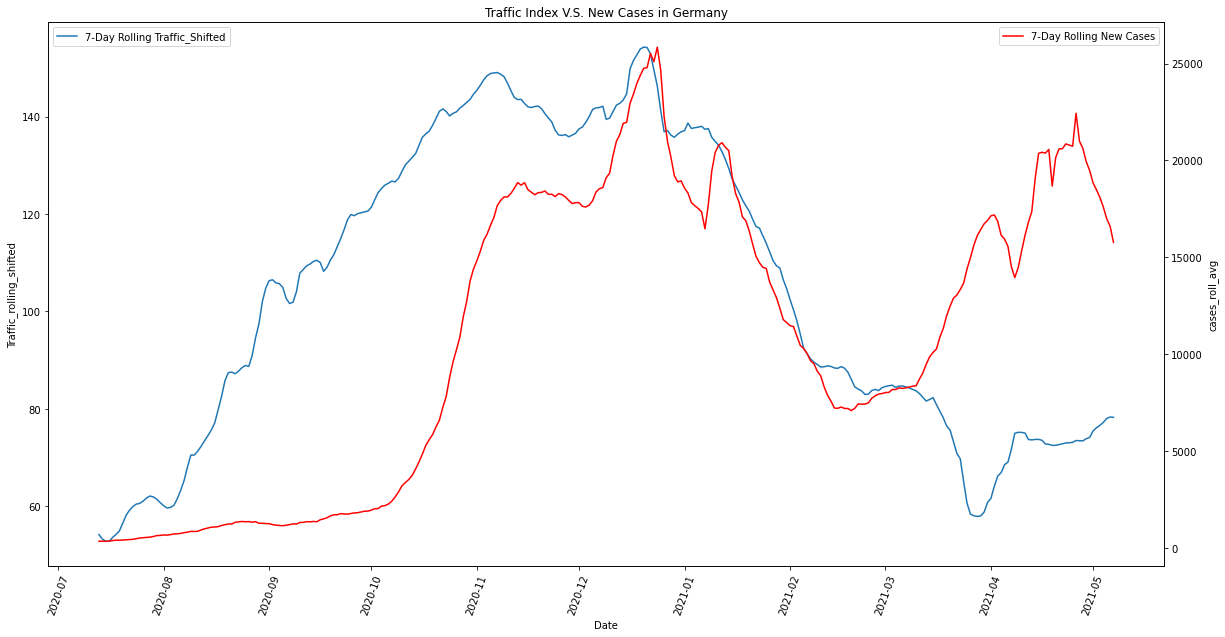

In [16]:
plot_Traffic_VS_Cases(finaldf, country = 'Germany' ,show_original_traffic=False)

In [17]:
def plot_corr_Traffic_VS_Cases(df, days2shift = 90, country = 'United States'):
    
    input_df = df[df['Country'] == country].reset_index().drop(columns=['index']).copy()
    
    input_df['Traffic_rolling_shifted'] = input_df['traffic_roll_avg'].shift(periods = days2shift, fill_value = 0)
    # plot_shift = max(days2shift, 180)
    df_plot = input_df[days2shift:]
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    ax = fig.add_subplot()
    sns.regplot(x=df_plot['Traffic_rolling_shifted'], y = df_plot['cases_roll_avg'], ci = 0)

    coef = df_plot[['Traffic_rolling_shifted', 'cases_roll_avg']].corr().iloc[0,1]
    title = f'7-Day Rolling Traffic Index shift {days2shift}days V.S. New Cases in {country} \n \
            the coef is {coef:.2f}'
    ax.set_title(title)

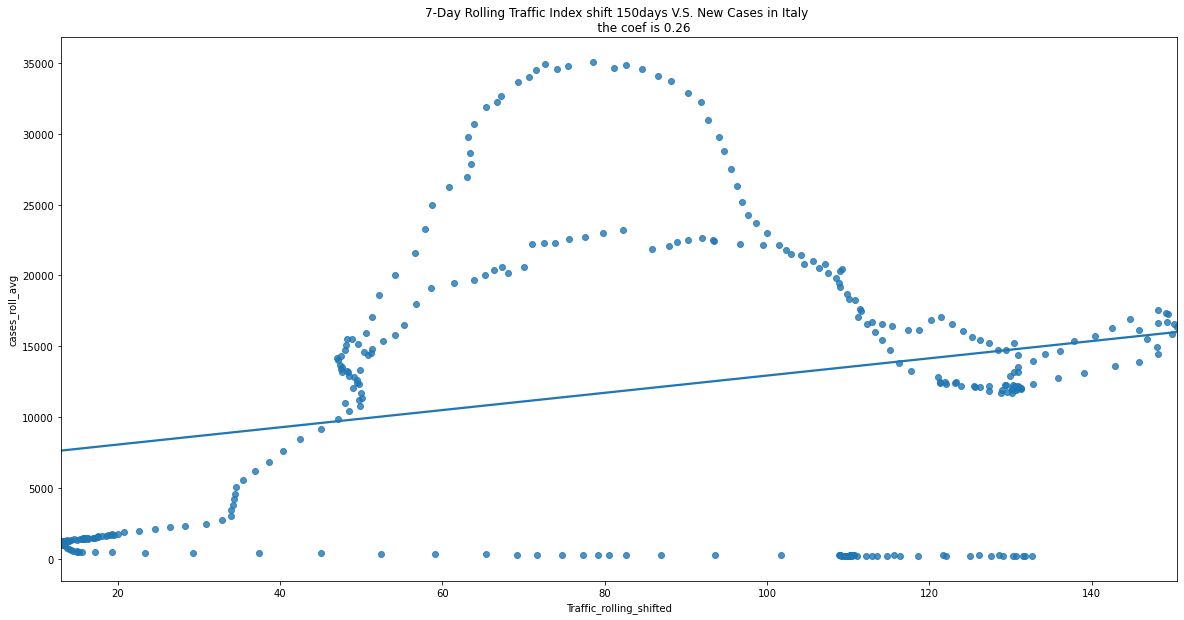

In [18]:
plot_corr_Traffic_VS_Cases(finaldf, days2shift=150, country='Italy')

In [19]:
df_USA['Traffic_rolling_shifted'] = df_USA['traffic_roll_avg'].shift(periods = 90, fill_value = 0)

In [27]:
# To allow further fine tuning of the date offset,
# we can use days as the unit and utilize the interact slider in ipywidgets

import ipywidgets as widgets
from ipywidgets import interact, Layout

@interact(days_to_shift = widgets.IntSlider(
    value = 100,
    min=-180,
    max=180,
    step=1,
    description='Days to Shift:',
    style = {'description_width': 'initial'},
    disabled=False,
    continuous_updaet=False,
    orientation = 'horizontal',
    readout=True,
    readout_format = 'd',
    layout=Layout(width='50%', height='80px')
)
)

def plotting(days_to_shift):
    i=1
    for country in finaldf['Country'].unique():
        df = finaldf[finaldf['Country']==country].copy()

        df['Traffic_rolling_shifted'] = df['traffic_roll_avg'].shift(periods = days_to_shift, fill_value = 0)
        df = df[days_to_shift:]

        fig = plt.gcf()
        fig.set_size_inches(15, 25)
        ax = fig.add_subplot(4, 2, i)
        i+=1
        
        sns.regplot(x=df['Traffic_rolling_shifted'],y=df['cases_roll_avg'], ax=ax, ci = 0, label='7-Day Rolling Traffic Shifted')

        ax.set_title('7-Day Rolling Traffic Index V.S. New Cases in {}'.format(country))
        plt.gcf().subplots_adjust(hspace=0.5, wspace=0.35)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

interactive(children=(IntSlider(value=100, description='Days to Shift:', layout=Layout(height='80px', width='5…